### Milestone 2:Milestone 2: Descriptive Statistics

### 2.1 : Loading Data and creating Database

In [1]:
import os
import json
import ast
%pip install ipython-sql
import pandas as pd
import sqlite3
%reload_ext sql
from collections import Counter
import itertools

tweets_path = os.path.join(os.getcwd(), "data/tweets.csv")
users_path = os.path.join(os.getcwd(), "data/users.csv")

tweets_df = pd.read_csv(tweets_path)
users_df = pd.read_csv(users_path)

tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], unit='s')
tweets_df['year'] = tweets_df['created_at'].dt.year
tweets_df["entities"] = tweets_df["entities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
tweets_df["hashtags"] = tweets_df["entities"].apply(lambda e: [h["text"] for h in e.get("hashtags", [])])
tweets_df["mentions"] = tweets_df["entities"].apply(lambda e: [m["screen_name"] for m in e.get("user_mentions", [])])
tweets_df["urls"] = tweets_df["entities"].apply(lambda e: [u["expanded_url"] for u in e.get("urls", [])])

# Convert lists/dicts into JSON strings before saving to SQLite
for col in ["entities", "hashtags", "mentions", "urls"]:
    if col in tweets_df.columns:
        tweets_df[col] = tweets_df[col].apply(lambda x: json.dumps(x) if isinstance(x, (dict, list)) else x)



conn = sqlite3.connect("congressional_tweets.db")
tweets_df.to_sql("tweets", conn, if_exists="replace", index=False)
users_df.to_sql("users", conn, if_exists="replace", index=False)

print("Both tables loaded into SQL successfully!")
%sql sqlite:///congressional_tweets.db

Note: you may need to restart the kernel to use updated packages.
Both tables loaded into SQL successfully!


### 2.2 : Basic descriptive statistics 

In [2]:
print("Tweets columns:", tweets_df.columns.tolist())
print("Users columns:", users_df.columns.tolist())

# ---  Example: Tweets per year (extract year from created_at) ---
query_year = """
SELECT strftime('%Y', created_at) AS year, COUNT(*) AS tweets_count
FROM tweets
GROUP BY year
ORDER BY year;
"""
df_year = pd.read_sql_query(query_year, conn)
print("\nTweets per year:\n", df_year)

# --- Example: Top 10 users by follower count ---
query_followers = """
SELECT screen_name, followers_count
FROM users
ORDER BY followers_count DESC
LIMIT 10;
"""
df_top_users = pd.read_sql_query(query_followers, conn)
print("\nTop 10 users by followers:\n", df_top_users)

# ---  Example: Average retweet & favorite count ---
query_engagement = """
SELECT AVG(retweet_count) AS avg_retweets, AVG(favorite_count) AS avg_favorites
FROM tweets;
"""
df_engagement = pd.read_sql_query(query_engagement, conn)
print("\nEngagement stats:\n", df_engagement)

Tweets columns: ['id', 'id_str', 'created_at', 'screen_name', 'user_id', 'text', 'lang', 'retweet_count', 'favorite_count', 'entities', 'in_reply_to_user_id', 'in_reply_to_screen_name', 'source', 'is_quote_status', 'quoted_status_id', 'year', 'hashtags', 'mentions', 'urls']
Users columns: ['id', 'id_str', 'screen_name', 'name', 'description', 'followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'verified', 'protected', 'created_at', 'location']

Tweets per year:
    year  tweets_count
0  2008           112
1  2009          8234
2  2010         13763
3  2011         35163
4  2012         50791
5  2013        124439
6  2014        168298
7  2015        258244
8  2016        354926
9  2017        229352

Top 10 users by followers:
        screen_name  followers_count
0  realDonaldTrump         31712585
1            POTUS         18545354
2       SenSanders          5072538
3       CoryBooker          3094413
4       marcorubio          2554822
5        SenWarren      

### 2.3 : User and Engagement Analysis

In [3]:
# top 10 active users by tweet count

query_top_users = """
SELECT 
    t.screen_name,
    u.followers_count,
    COUNT(*) AS total_tweets,
    AVG(t.retweet_count) AS avg_retweets,
    AVG(t.favorite_count) AS avg_favorites
FROM tweets t
JOIN users u
ON t.user_id = u.id
GROUP BY t.screen_name, u.followers_count
ORDER BY total_tweets DESC
LIMIT 10;
"""

df_top_users = pd.read_sql_query(query_top_users, conn)
print("Top 10 active users:\n", df_top_users)

# Ensure every element is a Python list
tweets_df['hashtags'] = tweets_df['hashtags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
tweets_df['mentions'] = tweets_df['mentions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 1) Count tweets with at least one hashtag / mention
tweets_with_hashtags = (tweets_df['hashtags'].apply(len) > 0).sum()
tweets_with_mentions = (tweets_df['mentions'].apply(len) > 0).sum()

print("Tweets with at least one hashtag:", tweets_with_hashtags)
print("Tweets with at least one mention:", tweets_with_mentions)

# 2) Flatten all lists to count top hashtags / mentions
all_hashtags = list(itertools.chain.from_iterable(tweets_df['hashtags']))
all_mentions = list(itertools.chain.from_iterable(tweets_df['mentions']))

# 3) Top 10
top_hashtags = Counter(all_hashtags).most_common(10)
top_mentions = Counter(all_mentions).most_common(10)

print("Top 10 Hashtags:", top_hashtags)
print("Top 10 Mentions:", top_mentions)

Top 10 active users:
        screen_name  followers_count  total_tweets  avg_retweets  avg_favorites
0      RepDonBeyer            31002          3257   1476.662880     105.599939
1    SenatorDurbin           148683          3252    153.135301     119.268758
2     GovMattBevin            25954          3250     43.810462      47.613231
3     MassGovernor           209707          3250     19.979077      28.786769
4       GrahamBlog           112365          3249     22.871345      19.828870
5    SenRonJohnson            59089          3249     19.616805       8.496153
6     SenTomCotton            68048          3249     26.307479      47.006464
7     onetoughnerd            61559          3249     12.170822      13.360419
8   RepScottPeters            15678          3248     59.641933      15.181958
9  GovMalloyOffice           116249          3246    226.144486       9.317006
Tweets with at least one hashtag: 611909
Tweets with at least one mention: 626471
Top 10 Hashtags: [('Obamaca

In [4]:
tweets_per_year = pd.read_sql_query("""
SELECT 
    year,
    COUNT(*) AS tweet_count
FROM tweets
GROUP BY year
ORDER BY year;
""", conn)

engagement_per_year = pd.read_sql_query("""
SELECT 
    year,
    AVG(retweet_count) AS avg_retweets,
    AVG(favorite_count) AS avg_favorites
FROM tweets
GROUP BY year
ORDER BY year;
""", conn)

print(tweets_per_year)
print(engagement_per_year)



tweets_exploded = tweets_df.explode('hashtags').dropna(subset=['hashtags'])
tweets_exploded[['year', 'hashtags']].to_sql('hashtags_table', conn, if_exists='replace', index=False)

# Top hashtags per year
top_hashtags_year = pd.read_sql_query("""
SELECT 
    year,
    hashtags,
    COUNT(*) AS count
FROM hashtags_table
GROUP BY year, hashtags
ORDER BY year, count DESC;
""", conn)

# Display top hashtags per year
top_hashtags_year.groupby('year').head(5)  # top 5 hashtags per year


   year  tweet_count
0  2008          112
1  2009         8234
2  2010        13763
3  2011        35163
4  2012        50791
5  2013       124439
6  2014       168298
7  2015       258244
8  2016       354926
9  2017       229352
   year  avg_retweets  avg_favorites
0  2008      0.000000       0.035714
1  2009      0.194438       0.143551
2  2010      3.103538       0.179975
3  2011      4.372238       0.178682
4  2012     11.784214       0.525251
5  2013     18.419386       1.847885
6  2014     69.718850       5.721054
7  2015     60.616158       9.472073
8  2016    182.093898     278.323448
9  2017    615.291718     642.126918


,year,hashtags,count
0,2008,pork,8
1,2008,tcot,2
2,2008,flake,2
3,2008,rnc08,1
4,2008,TCOT,1
5,2009,tcot,528
6,2009,sctweets,364
7,2009,TCOT,232
8,2009,masen,164
9,2009,healthcare,144


### 2.4 : Plotting the Data

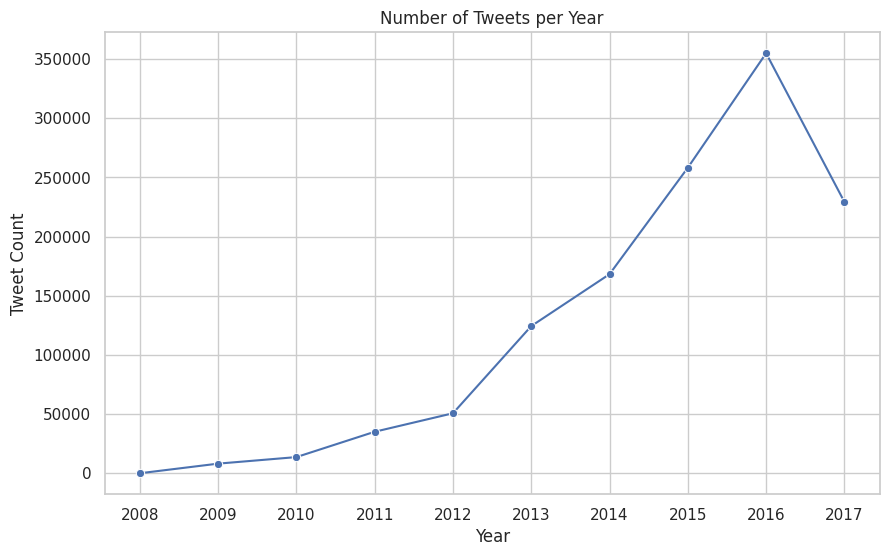

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

#Number of Tweets Per Year
tweets_per_year = tweets_df.groupby('year').size().reset_index(name='tweet_count')

plt.figure(figsize=(10,6))
sns.lineplot(data=tweets_per_year, x='year', y='tweet_count', marker='o')
plt.title('Number of Tweets per Year')
plt.xlabel('Year')
plt.ylabel('Tweet Count')
plt.xticks(tweets_per_year['year'])
plt.show()

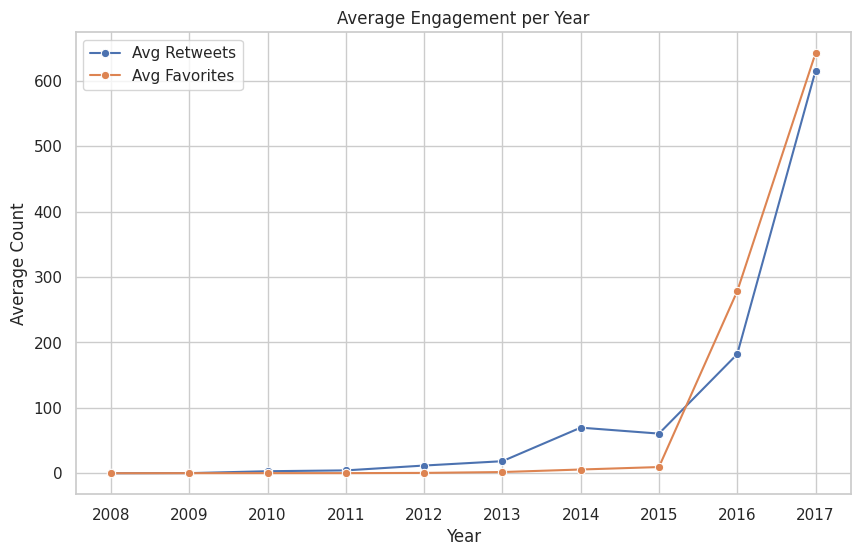

In [6]:
#Average Retweets & Favorites Per Year
engagement_per_year = tweets_df.groupby('year')[['retweet_count', 'favorite_count']].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=engagement_per_year, x='year', y='retweet_count', marker='o', label='Avg Retweets')
sns.lineplot(data=engagement_per_year, x='year', y='favorite_count', marker='o', label='Avg Favorites')
plt.title('Average Engagement per Year')
plt.xlabel('Year')
plt.ylabel('Average Count')
plt.xticks(engagement_per_year['year'])
plt.legend()
plt.show()


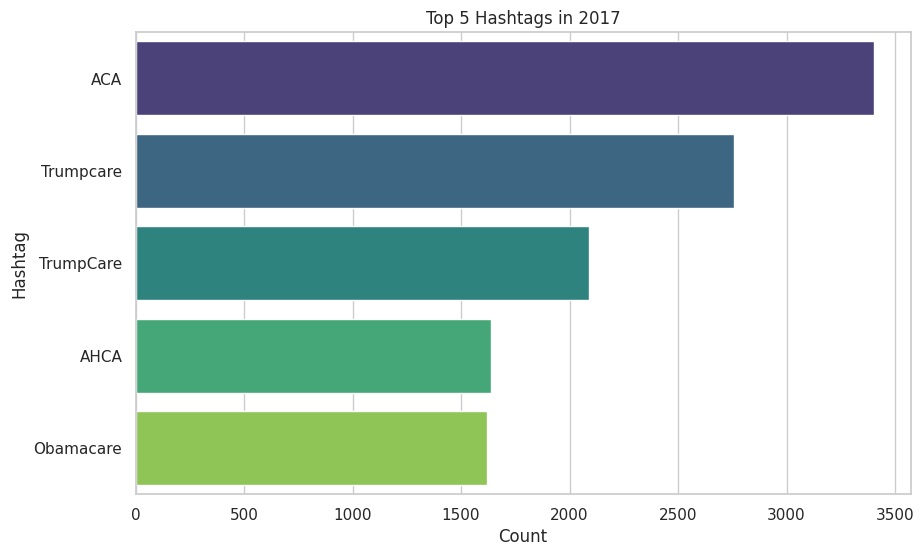

In [7]:
#Top Hashtags Per Year

# Explode hashtags
tweets_exploded = tweets_df.explode('hashtags').dropna(subset=['hashtags'])

# Count top hashtags per year
top_hashtags_year = (tweets_exploded.groupby(['year', 'hashtags'])
                     .size()
                     .reset_index(name='count'))

# Plot top 5 hashtags for a selected year, e.g., 2017
year = 2017
top5 = top_hashtags_year[top_hashtags_year['year'] == year].sort_values(by='count', ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(data=top5, x='count', y='hashtags', hue='hashtags', palette='viridis', dodge=False, legend=False)
plt.title(f'Top 5 Hashtags in {year}')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.show()
